In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import os
import tensorflow_datasets
import time

In [2]:
#导入数据
examples, info = tensorflow_datasets.load('ted_hrlr_translate/pt_to_en', with_info=True,as_supervised=True)
train_data, val_data = examples['train'], examples['validation']
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/home/seal/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    citation="""@inpr

In [3]:
en_tokenizer = tensorflow_datasets.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for en,pt in train_data),target_vocab_size= 2**13)
pt_tokenizer = tensorflow_datasets.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for en,pt in train_data),target_vocab_size= 2**13)


In [33]:
#数据预处理
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):#词汇表里有0 ~ vacab_size-1的序号，所以用vacab_size和vocab_size+1作为开始和结束的标识符
    en_sequence =[en_tokenizer.vocab_size]\
    +en_tokenizer.encode(en_sentence.numpy())\
    +[en_tokenizer.vocab_size+1]
    
    pt_sequence =[pt_tokenizer.vocab_size]\
    +pt_tokenizer.encode(pt_sentence.numpy())\
    +[pt_tokenizer.vocab_size+1]
    
    return pt_sequence, en_sequence

def filter_by_max_length(pt, en):    #判断长度是否<=40
    return tf.logical_and(tf.size(pt) <=max_length, tf.size(en) <=max_length)
    
def tf_encode_to_subword(pt_sentence, en_sentence):    #进行pyfunction的封装
    return tf.py_function(encode_to_subword,[pt_sentence, en_sentence], [tf.int64, tf.int64])
    
#生成训练与验证的数据集
train_dataset = train_data.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)     #舍弃长度大于40的数据
train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size,padded_shapes= ([-1], [-1]))    #随机打乱数据， 将每64个样本补成相同长度

val_dataset = val_data.map(tf_encode_to_subword)
val_dataset = val_dataset.filter(filter_by_max_length)     #舍弃长度大于40的数据
val_dataset = val_dataset.padded_batch(batch_size, padded_shapes= ([-1], [-1]))    #将每64个样本补成相同长度

In [34]:
for en,pt in val_dataset.take(5):
    print(en.shape,pt.shape)

(64, 40) (64, 39)
(64, 40) (64, 38)
(64, 40) (64, 40)
(64, 40) (64, 39)
(64, 40) (64, 40)


In [6]:
#位置编码
#pos.shape:[sample_length, 1]
#i.shape = angles.shape = [1,d_model]
#result.shape = [sample_length, d_model]

def get_angles(pos, i, d_model):     #position:词语在句子中的位置， i:词语在embedding中的位置， d_model:embedding的大小
    angle_rates = 1/np.power(10000, (i//2) * 2/np.float32(d_model))
    return pos*angle_rates
    
def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:,np.newaxis],         #生成一个shape为[sentence_length, 1]的矩阵
                            np.arange(d_model)[np.newaxis, :],                 #生成一个shape为[1, d_model]的矩阵
                            d_model)
    sines = np.sin(angle_rads[:, 0::2])   #偶数位
    cosines = np.cos(angle_rads[:, 1::2])   #奇数位
    position_embedding = np.concatenate([sines, cosines], axis = 1)
    position_embedding = position_embedding[np.newaxis, ...]   #在最前面扩展出一个新的维度
    #shape:[1, sentence_length, d_model]
    return tf.cast(position_embedding, dtype= tf.float32)   #数据类型转换


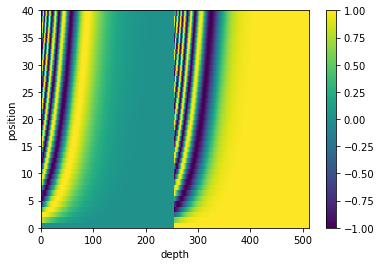

In [7]:
position_embedding = get_position_embedding(40, 512)

#绘制position_embedding
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0])
    plt.colorbar()
    plt.xlabel('depth')
    plt.ylabel('position')

plot_position_embedding(position_embedding)

In [8]:
#padding mask
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)       #将填充0部分的值设为1
    return padding_mask[:, tf.newaxis, tf.newaxis, :]       #为便于后续计算，在中间添加两个维度

#测试padding mask
x = tf.constant([[1,4,0], [3, 0, 8]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1.]]]


 [[[0. 1. 0.]]]], shape=(2, 1, 1, 3), dtype=float32)


In [9]:
#look_ahead_mask
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)     #将右上角要去掉的部分的值设为1
    return mask
#测试look_ahead_mask
create_look_ahead_mask(4)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

In [10]:
#缩放点积注意力机制
def scaled_dot_product_attention(q, k, v, mask):
#     args:
#         q: shape == [..., seq_len_q, depth]
#         k: shape == [..., seq_len_k, depth]
#         v: shape == [..., seq_len_v, depth_v]
#         seq_length_k = seq_length_v （矩阵乘法）
#         mask_shape = (..., seq_length_q, seq_length_k)\
#     returns:
#         output: weighted_sum
#         attention_weights: weights_of_attention (alpha)
    matmul_qk = tf.matmul(q, k, transpose_b=True)        #矩阵乘法, k取转置
    dk = tf.cast(tf.shape(k)[-1], tf.float32)            #类型转换
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    #添加mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)       #将要去掉的部分的值加上-1e9,在softmax之后值趋近于0
    #计算alpha
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis= -1)    #shape = (... , seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)          #shape = (... , seq_len_q, depth)
    return output, attention_weights


In [11]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()     #继承父类的构造方法
        self.d_model = d_model
        self.num_heads = num_heads
        assert self.d_model %self.num_heads == 0
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)     #三个全连接层用来计算qkv
        
        self.WK= keras.layers.Dense(self.d_model)
        self.WV= keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
        
    
    def split_heads(self, x, batch_size):
        #多头注意力机制的实现，对x进行reshape：（batch_size, seq_len, d_model）-> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x,(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])     #这里维度转换是因为attention计算使用的是后两个维度
    
    def call(self, q, k, v, mask):
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)
        
        batch_size = tf.shape(q)[0]
        q = self.split_heads(q, batch_size)     #shape: (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        #reshape： (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        outputs = tf.transpose(outputs, perm=[0,2,1,3])
        #合并后两个维度
        concat_attention = tf.reshape(outputs, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)    #output.shape = (batch_size, seq_len, d_model)
        return output, attention_weights

In [12]:
#测试multihead
temp = MultiHeadAttention(d_model = 512, num_heads = 8)
x = tf.random.uniform((1,60, 256))    #(batch_size, seq_len, dim)
output, attention = temp(x,x,x,mask = None)
print(output.shape, attention.shape)


(1, 60, 512) (1, 8, 60, 60)


In [13]:
def feed_forward_network(d_model, dff):       #dff: dim of ffn
    return keras.Sequential([
        keras.layers.Dense(dff, activation = 'relu'), 
        keras.layers.Dense(d_model)
    ])

In [14]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & norm & dropout-> feed forward -> add & norm & dropout 
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):           #rate: 用于drop out
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        #x.shape: (batch_size, seq_len, dim) dim是embedding的维度或者上一层的维度
        attention_output, _ = self.mha(x,x,x,mask)    #self attention的qkv都是自己
        attention_output = self.dropout1(attention_output, training = training) #告诉dropout是训练还是测试
        out1 = self.layer_norm1(x + attention_output)   #残差连接
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        out2 = self.layer_norm2(ffn_output + out1)
        
        return out2


In [15]:
#测试Encoder Layer
sample_encoder_layer = EncoderLayer(512,8, 2048)
sample_input = tf.random.uniform((64,50,512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


In [16]:
class DecoderLayer(keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)    #self attention
        self.mha2 = MultiHeadAttention(d_model, num_heads)    #encoder-decoder attention
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        #x.shape : (batch_size, target_seq_len, d_model)
        #encoding_outputs.shape: (batch_size, input_seq_length, d_model)
        
        attention1, weights1 = self.mha1(x,x,x,decoder_mask)       #self attention
        attention1 = self.dropout1(attention1, training = training)
        out1 = self.layer_norm1(attention1 + x)
        
        attention2, weights2 = self.mha2(out1, encoding_outputs, encoding_outputs, encoder_decoder_padding_mask)  #encoder-decoder attention
        attention2 = self.dropout2(attention2, training = training)
        out2 = self.layer_norm2(attention2 + out1)
        
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training = training)
        out3 = self.layer_norm3(ffn_out + out2)      #out3.shape : (batch_size, target_seq_len, d_model)
        
        return out3, weights1, weights2
    

In [17]:
#测试decoder layer
decoder_layer = DecoderLayer(512,8,2048)
decoder_input = tf.random.uniform((64, 60, 512))
output, weight1, weight2 = decoder_layer(decoder_input, sample_output, False, None, None)
print(output.shape, weight1.shape, weight2.shape)

(64, 60, 512) (64, 8, 60, 60) (64, 8, 60, 50)


In [35]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length, d_model, num_heads, dff, rate = 0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
        self.position_embedding = get_position_embedding(max_length, self.d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, training, mask):
        input_seq_length = tf.shape(x)[1]    #x.shape : (batch_size, seq_len)
        tf.debugging.assert_less_equal(input_seq_length, self.max_length, 
                                       "input_seq_len shoule be less or equal to self.max_length")
        
        x = self.embedding(x)     #x.shape -> (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    #对x进行缩放，增加x的影响
        #position_embedding.shape = （1，max_length, d_model)
        x += self.position_embedding[:, :input_seq_length, :]    #进行切片操作，使得x与embedding能够相加。x的batch size中的每一份都会加上一个position embedding
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, mask)
        return x
        

In [36]:
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input, False, None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [37]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length, d_model, num_heads, dff, rate = 0.1):
        super(DecoderModel, self).__init__()
        
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        self.position_embedding = get_position_embedding(max_length, d_model)
        self.dropout = keras.layers.Dropout(rate)
        
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        #x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(output_seq_len, self.max_length,"output_seq_len shoule be less or equal to self.max_length")
        
        x = self.embedding(x)     #x.shape = (batch_size, output_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))      #类似Encoder model
        x += self.position_embedding[:, :output_seq_len, :]
        x = self.dropout(x, training = training)
        
        attention_weights = {}
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
            attention_weights['decoder_layer{}_attn1'.format(i+1)] = attn1
            attention_weights['decoder_layer{}_attn2'.format(i+1)] = attn2
        return x, attention_weights

In [38]:
#测试Decoder Model
sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_attention = sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,
    training = False,
    decoder_mask = None,
    encoder_decoder_padding_mask = None
                                                                                  )
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_attention:
    print(sample_decoder_model_attention[key].shape)    
#结果说明：decoder model有两个decoder layer，每个layer分别包括decoder self attention（35，35）和encoder-decoder attention（35，37）

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [39]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size, max_length, d_model, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(num_layers, input_vocab_size, max_length, d_model, num_heads, dff, rate)
        self.decoder_model = DecoderModel(num_layers, target_vocab_size, max_length, d_model, num_heads, dff, rate)
        self.final_layer = keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask):
        encoding_outputs = self.encoder_model(inp, training, encoder_padding_mask)
        decoding_outputs, attention_weights = self.decoder_model(tar, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
        predictions = self.final_layer(decoding_outputs)
        return predictions, attention_weights

In [40]:
sample_transformer = Transformer(2, 8500, 8000, max_length, 512, 8, 2048)
sample_transformer_input = tf.random.uniform((64, 26))
sample_transformer_target = tf.random.uniform((64, 31))

sample_transformer_predictions, sample_transformer_attn = sample_transformer(
    sample_transformer_input, 
    sample_transformer_target,
    False, None, None, None)

print(sample_transformer_predictions.shape)
for key in sample_transformer_attn:
    print(key, sample_transformer_attn[key].shape)

(64, 31, 8000)
decoder_layer1_attn1 (64, 8, 31, 31)
decoder_layer1_attn2 (64, 8, 31, 26)
decoder_layer2_attn1 (64, 8, 31, 31)
decoder_layer2_attn2 (64, 8, 31, 26)


In [41]:
#1.初始化模型
# 2.定义loss, learning rate schedule, optimizer
# 3.train step
# 4.train process

num_layers = 4
d_model = 128      #模型的size
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
dropout_rate = 0.1

transformer = Transformer(num_layers, input_vocab_size, target_vocab_size, 
                          max_length, d_model, num_heads, dff, dropout_rate)

In [42]:
#论文中learning rate的调整方法
#lrate = (d_model ** (-0.5)) * min(step_num ** (-0.5), step_number * warm_up_steps ** (-1.5))
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warm_up_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warm_up_steps = warm_up_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)     #step num ** -0.5
        arg2 = step * (self.warm_up_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg2, arg1)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, beta_1= 0.9, beta_2 = 0.98, epsilon= 1e-9)


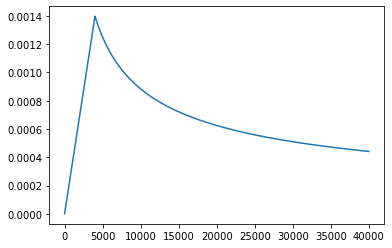

In [43]:
sample_learning_rate_schedule = CustomizedSchedule(d_model)
plt.plot(sample_learning_rate_schedule(tf.range(40000, dtype = tf.float32)))


In [44]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype= loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [45]:
def create_masks(inp, tar):
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    #decoder mask包括look ahead mask, padding mask
    decoder_mask = tf.maximum(look_ahead_mask, decoder_padding_mask)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [46]:
tmp_inp, tmp_tar = iter(train_dataset.take(1)).next()
print(tmp_inp.shape)
print(tmp_tar.shape)
create_masks(tmp_inp, tmp_tar)

(64, 40)
(64, 39)


(<tf.Tensor: shape=(64, 1, 1, 40), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 39, 39), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

In [49]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, encoder_padding_mask, 
                                    decoder_mask, encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
epochs = 20      #遍历次数
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch %100 == 0:
            print('Epoch{}, Batch{}, Loss{:.4f}, Accuracy{:.4f}'.format(epoch+1, batch, 
                                                                        train_loss.result(), 
                                                                        train_accuracy.result()))
    print('Epoch{}, Loss{:.4f}, Accuracy{:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))   
    print('time take for 1 epoch: {}seconds\n'.format(time.time()-start))

Epoch1, Batch0, Loss5.0322, Accuracy0.0502


Epoch1, Batch100, Loss5.0245, Accuracy0.0538
Epoch1, Batch200, Loss4.7259, Accuracy0.0533


KeyboardInterrupt: 